## Import Libraries & Data

In [88]:
import os
import folium
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
from folium.features import GeoJsonTooltip
from sklearn.preprocessing import MinMaxScaler

In [127]:
# Merged Rental History Feature Sets
one_bed_flat_merged = pd.read_csv('../data/curated/merged_feature_set/one_bed_flat_merged.csv')
two_bed_flat_merged = pd.read_csv('../data/curated/merged_feature_set/two_bed_flat_merged.csv')
three_bed_flat_merged = pd.read_csv('../data/curated/merged_feature_set/three_bed_flat_merged.csv')

two_bed_house_merged = pd.read_csv('../data/curated/merged_feature_set/two_bed_house_merged.csv')
three_bed_house_merged = pd.read_csv('../data/curated/merged_feature_set/three_bed_house_merged.csv')
four_bed_house_merged = pd.read_csv('../data/curated/merged_feature_set/four_bed_house_merged.csv')

all_properties_merged = pd.read_csv('../data/curated/merged_feature_set/all_properties_merged.csv')

## Get the Livability Index

In [128]:
def get_livability(df):

    # Get the columns that are relevant in determining livability

    crime = df.filter(regex='^offence_division.*').columns
    education_count = df.filter(regex='^(?!.*furnished).*_count$').columns
    education_rank = df.filter(regex='.*_rank$').columns
    distances = df.filter(regex='.*distance.*').columns

    points_of_interest = ['park', 'cycleway', 'walking_paths', 'culture_and_leisure', 'financial_institutions', 
        'food_and_beverage','healthcare', 'public_facilities', 'shopping_and_retail','tourism_and_attractions',
        'accommodation', 'pofw_count']

    columns_to_normalize = list(crime) + list(education_count) + list(education_rank) + list(distances) + points_of_interest

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Normalise the columns
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # Invert
    df[crime] = 1 - df[crime] # Crime should be negatively correlated with livability
    df[distances] = 1 - df[distances] # Larger distances to public transports, hospitals, cbd etc. are also negatively correlated with livability
    df[education_rank] = 1 - df[education_rank] # Higher rank (lower number) means better livability

    # Sum up the livability scores
    df['livability'] = (
        df[crime].sum(axis=1) +  
        df[education_count].sum(axis=1) + 
        df[education_rank].sum(axis=1) + 
        df[distances].sum(axis=1) +
        df[points_of_interest].sum(axis=1)
    )

    # Normalise to (0,1) scale
    df['livability'] = scaler.fit_transform(df[['livability']])

    return df[['year', 'suburb', 'livability']]

livability_one_bed_flat = get_livability(one_bed_flat_merged)
livability_two_bed_flat = get_livability(two_bed_flat_merged)
livability_three_bed_flat = get_livability(three_bed_flat_merged)

livability_two_bed_house = get_livability(two_bed_house_merged)
livability_three_bed_house = get_livability(three_bed_house_merged)
livability_four_bed_house = get_livability(four_bed_house_merged)

livability_all_properties = get_livability(all_properties_merged)

In [129]:
# Save livability data as csv's to merge with the final feature set
def save_livability_data():
    
    # Define the base path
    base_path = '../data/curated/livability'

    # Ensure the directory exists
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Save each dataframe to a CSV file
    livability_one_bed_flat.to_csv(os.path.join(base_path, 'livability_one_bed_flat.csv'), index=False)
    livability_two_bed_flat.to_csv(os.path.join(base_path, 'livability_two_bed_flat.csv'), index=False)
    livability_three_bed_flat.to_csv(os.path.join(base_path, 'livability_three_bed_flat.csv'), index=False)
    livability_two_bed_house.to_csv(os.path.join(base_path, 'livability_two_bed_house.csv'), index=False)
    livability_three_bed_house.to_csv(os.path.join(base_path, 'livability_three_bed_house.csv'), index=False)
    livability_four_bed_house.to_csv(os.path.join(base_path, 'livability_four_bed_house.csv'), index=False)
    livability_all_properties.to_csv(os.path.join(base_path, 'livability_all_properties.csv'), index=False)

# Call the function
save_livability_data()

## Get Average Livability Index per Suburb for Visualisations

In [130]:
# Find the average livability index per suburb across years
average_livability_one_bed_flat = livability_one_bed_flat.groupby('suburb')['livability'].mean().reset_index()
average_livability_two_bed_flat = livability_two_bed_flat.groupby('suburb')['livability'].mean().reset_index()
average_livability_three_bed_flat = livability_three_bed_flat.groupby('suburb')['livability'].mean().reset_index()

average_livability_two_bed_house = livability_two_bed_house.groupby('suburb')['livability'].mean().reset_index()
average_livability_three_bed_house = livability_three_bed_house.groupby('suburb')['livability'].mean().reset_index()
average_livability_four_bed_house = livability_four_bed_house.groupby('suburb')['livability'].mean().reset_index()

average_livability_all_properties = livability_all_properties.groupby('suburb')['livability'].mean().reset_index()

In [95]:
flats = [average_livability_one_bed_flat, average_livability_two_bed_flat, average_livability_three_bed_flat]
houses = [average_livability_two_bed_house, average_livability_three_bed_house, average_livability_four_bed_house]

flat_titles = ['1 Bed Flat', '2 Bed Flat', '3 Bed Flat']
house_titles = ['2 Bed House', '3 Bed House', '4 Bed House']

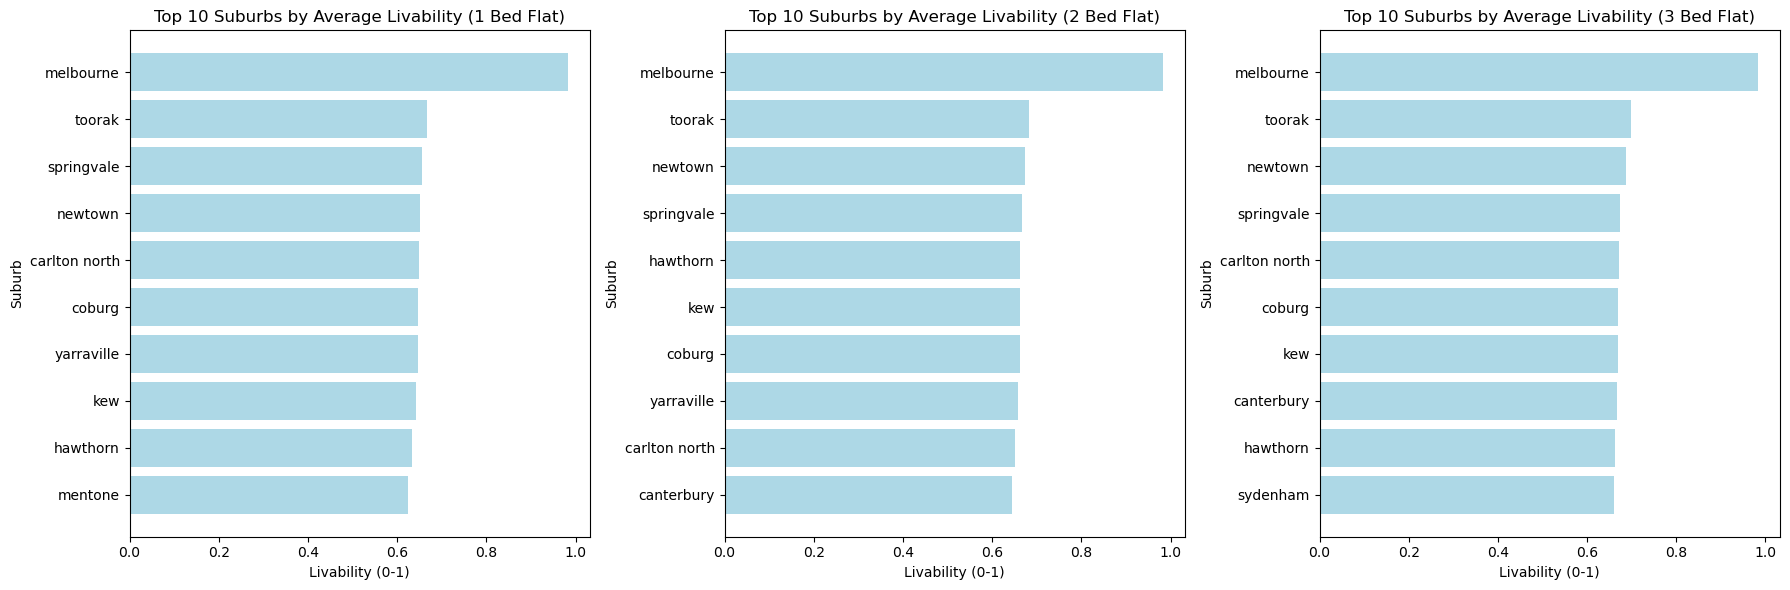

In [101]:
ig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
axes = axes.flatten()

# Loop through each DataFrame and plot for flats
for i, df in enumerate(flats):
    top_10 = df.sort_values(by='livability', ascending=False).head(10)
    axes[i].barh(top_10['suburb'], top_10['livability'], color='lightblue')
    axes[i].set_title(f'Top 10 Suburbs by Average Livability ({flat_titles[i]})')
    axes[i].set_xlabel('Livability (0-1)')
    axes[i].set_ylabel('Suburb')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig("../plots/most_livable_suburbs_flats.png")
plt.show()

#flat_suburbs = ['melbourne', 'toorak', 'springvale', 'newtown', 'carlton north', 'coburg', 'kew', 'hawthorn','yarraville (2)']

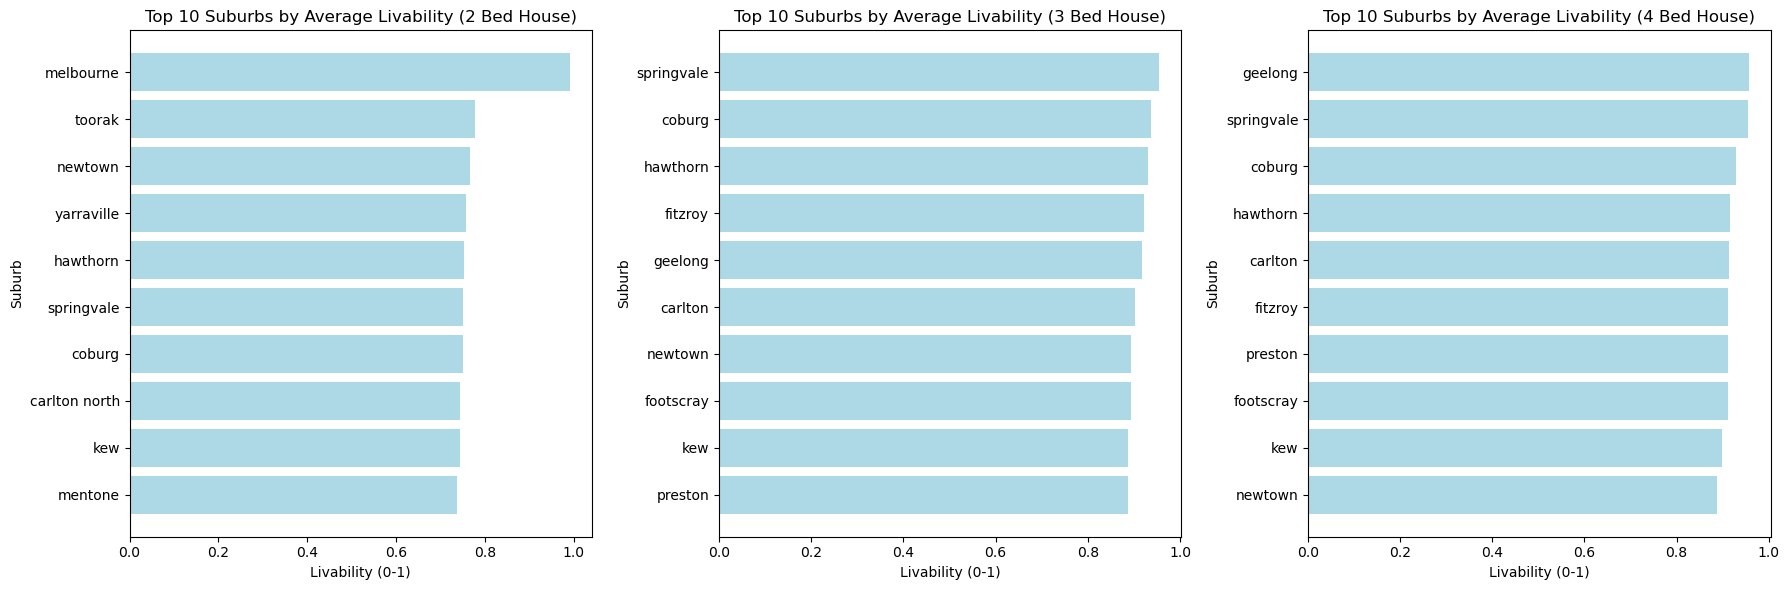

In [103]:
# Plot for houses
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
axes = axes.flatten()

# Loop through each DataFrame and plot for houses
for i, df in enumerate(houses):
    top_10 = df.sort_values(by='livability', ascending=False).head(10)
    axes[i].barh(top_10['suburb'], top_10['livability'], color='lightblue')
    axes[i].set_title(f'Top 10 Suburbs by Average Livability ({house_titles[i]})')
    axes[i].set_xlabel('Livability (0-1)')
    axes[i].set_ylabel('Suburb')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig("../plots/most_livable_suburbs_houses.png")
plt.show()

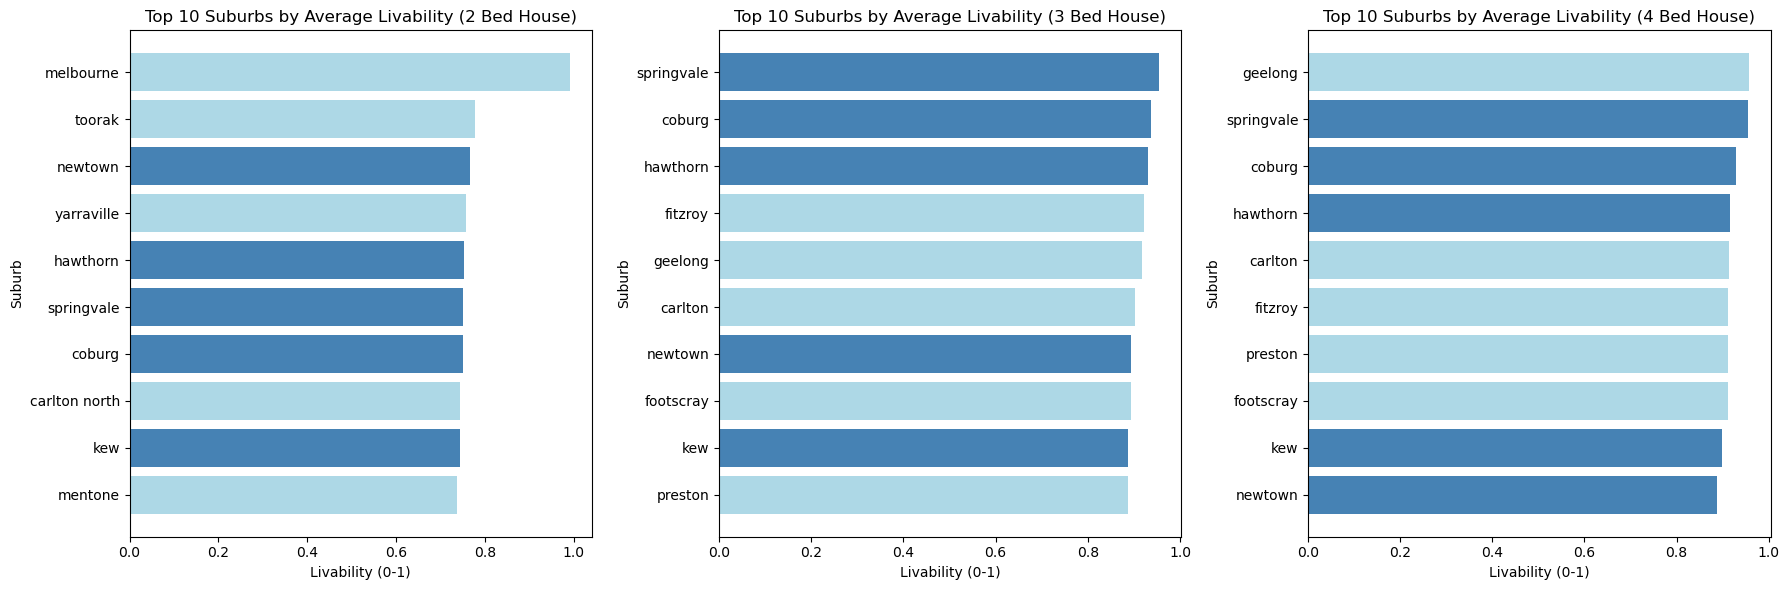

In [104]:
# Define list of suburbs to highlight
house_suburbs = ['springvale', 'newtown', 'hawthorn', 'coburg', 'kew']

# Plot for houses
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
axes = axes.flatten()

# Loop through each DataFrame and plot for houses
for i, df in enumerate(houses):
    top_10 = df.sort_values(by='livability', ascending=False).head(10)
    house_colors = ['steelblue' if suburb in house_suburbs else 'lightblue' for suburb in top_10['suburb']]

    axes[i].barh(top_10['suburb'], top_10['livability'], color=house_colors)
    axes[i].set_title(f'Top 10 Suburbs by Average Livability ({house_titles[i]})')
    axes[i].set_xlabel('Livability (0-1)')
    axes[i].set_ylabel('Suburb')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig("../plots/highlighted_most_livable_suburbs_houses.png")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

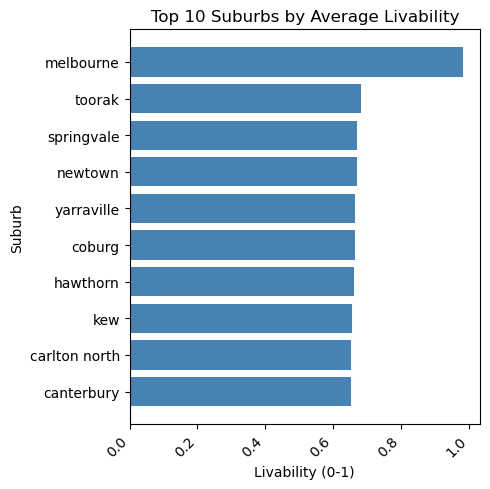

In [99]:
top_10_livability_all = average_livability_all_properties.sort_values(by='livability', ascending=False).head(10)

plt.figure(figsize=(5, 5))

plt.barh(top_10_livability_all['suburb'], top_10_livability_all['livability'], color = 'steelblue')

# Add titles and labels
plt.title('Top 10 Suburbs by Average Livability')
plt.xlabel('Livability (0-1)')
plt.ylabel('Suburb')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Invert the y-axis so the highest population is at the top
plt.gca().invert_yaxis()

# Display the bar chart
plt.tight_layout()
plt.savefig("../plots/most_livable_suburbs_all.png")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

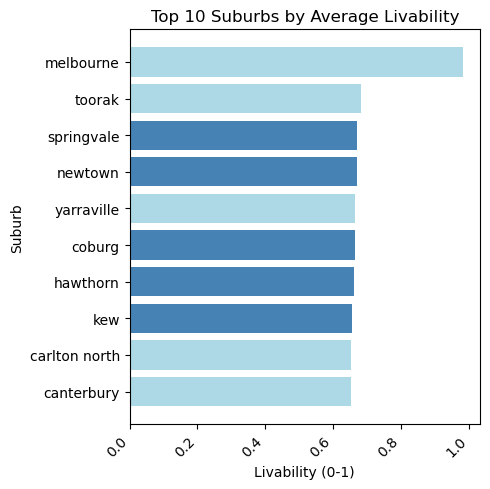

In [107]:
highlight_suburbs = ['springvale', 'coburg', 'kew', 'hawthorn', 'newtown']

# Define colors: Highlighted suburbs in 'crimson', others in 'steelblue'
colors = ['steelblue' if suburb in highlight_suburbs else 'lightblue' for suburb in top_10_livability_all['suburb']]

plt.figure(figsize=(5, 5))

plt.barh(top_10_livability_all['suburb'], top_10_livability_all['livability'], color = colors)

# Add titles and labels
plt.title('Top 10 Suburbs by Average Livability')
plt.xlabel('Livability (0-1)')
plt.ylabel('Suburb')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Invert the y-axis so the highest population is at the top
plt.gca().invert_yaxis()

# Display the bar chart
plt.tight_layout()
plt.savefig("../plots/highlighted_most_livable_suburbs_all.png")
plt.show()

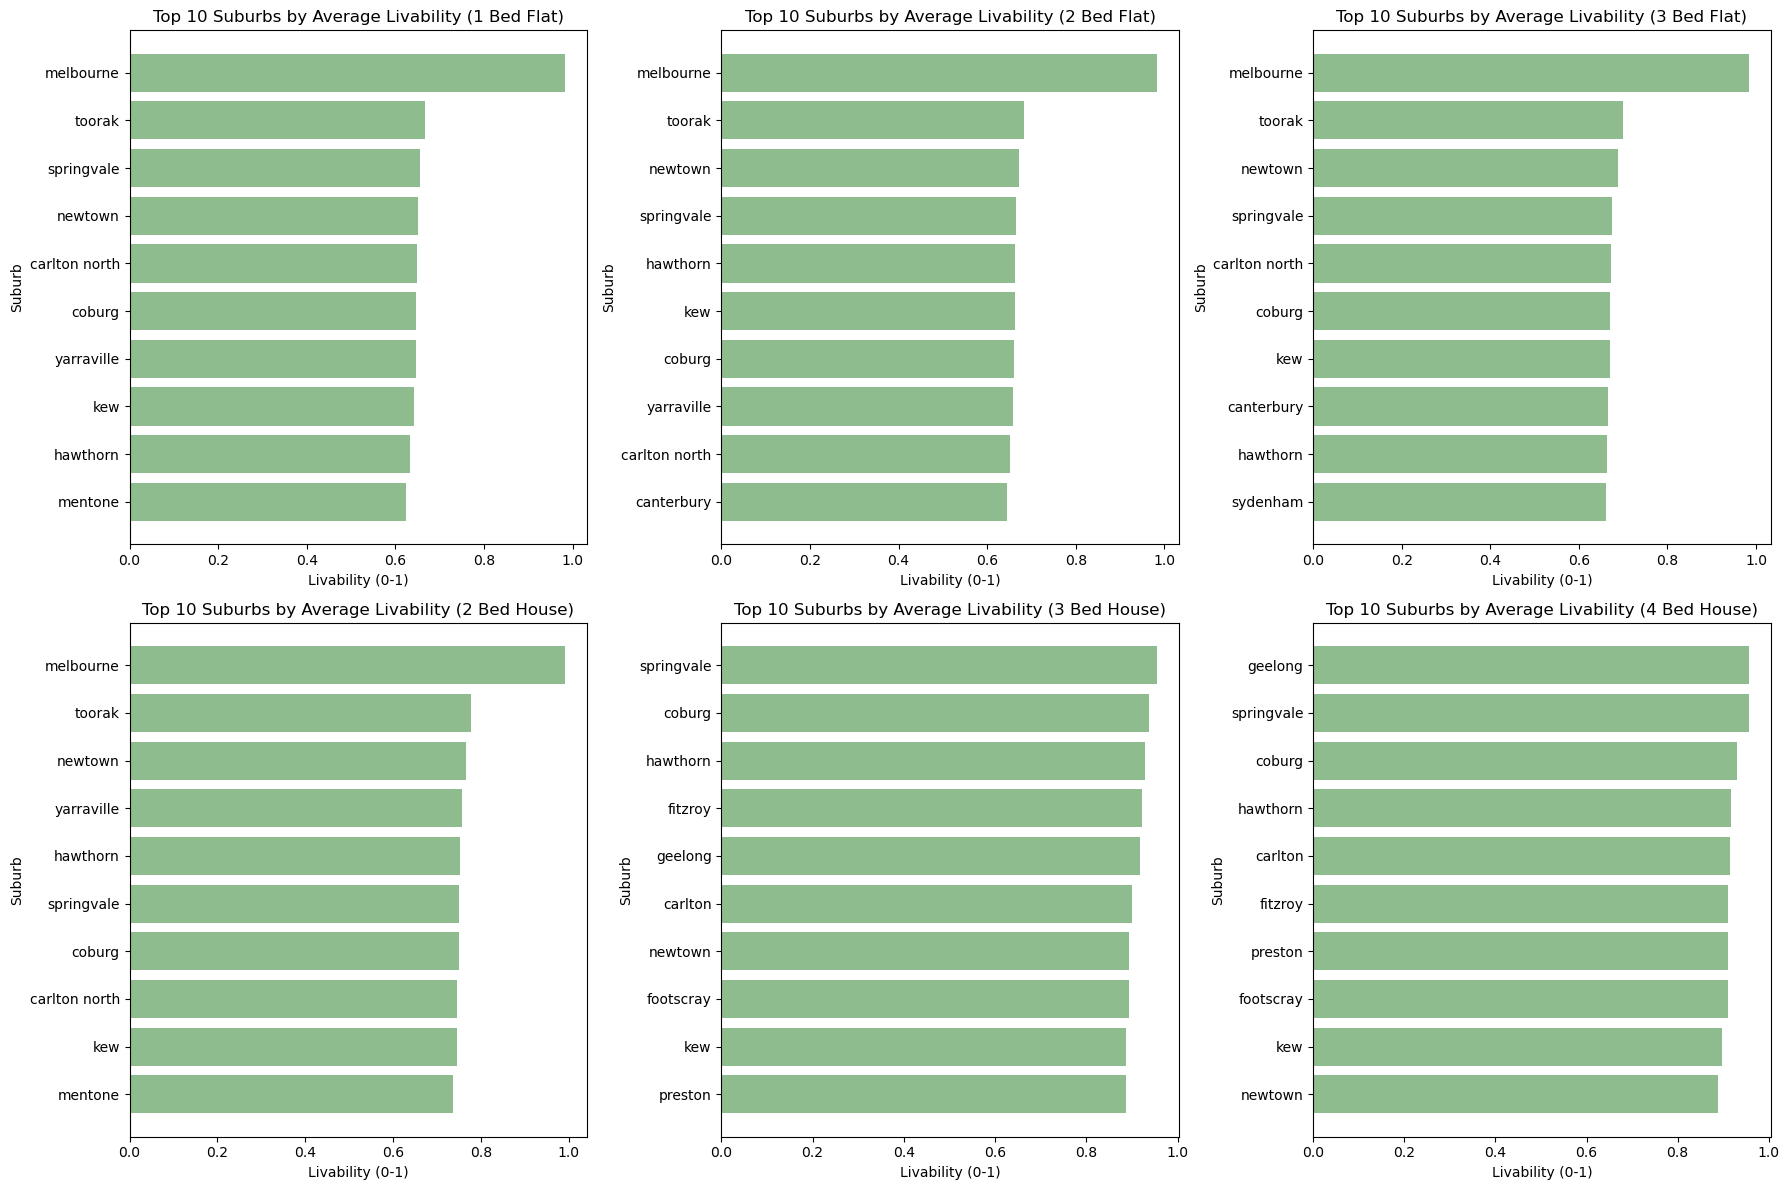

In [111]:
# Overall Visualisations 
dataframes = flats + houses

# Titles for each subplot
titles = flat_titles + house_titles

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten()  # Flatten to 1D array to easily index each axis

# Loop through each DataFrame and plot it on a corresponding subplot
for i, df in enumerate(dataframes):

    # Sort the DataFrame by livability and select top 10 suburbs
    top_10 = df.sort_values(by='livability', ascending=False).head(10)

    # Plot the horizontal bar chart on the i-th axis
    axes[i].barh(top_10['suburb'], top_10['livability'], color='darkseagreen')

    # Add titles and labels
    axes[i].set_title(f'Top 10 Suburbs by Average Livability ({titles[i]})')
    axes[i].set_xlabel('Livability (0-1)')
    axes[i].set_ylabel('Suburb')

    # Invert the y-axis so the highest livability is at the top
    axes[i].invert_yaxis()

# Automatically adjust layout to avoid overlap
plt.tight_layout()

# Save the plot
plt.savefig("../plots/most_livable_suburbs.png")

# Display the plot
#plt.show()


## Heat Map

In [19]:
vic_suburbs_gdf = gpd.read_file('../data/map/Vic_Localities/gda2020_vicgrid/esrishape/whole_of_dataset/victoria/VMADMIN/LOCALITY_POLYGON.shp')
vic_suburbs_gdf = vic_suburbs_gdf.to_crs(epsg=4326)
vic_suburbs_gdf['suburb'] = vic_suburbs_gdf['GAZLOC'].str.lower()

merged = vic_suburbs_gdf.merge(average_livability_all_properties, on='suburb')

merged = merged.drop(columns=['PFI_CR', 'UFI_OLD', 'UFI_CR'], errors='ignore')

In [109]:
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=10, tiles="cartodb positron")

# Add the choropleth map for population with a better color scheme and highlight on hover
choropleth = folium.Choropleth(
    geo_data=merged.__geo_interface__,    # Geopandas dataframe in GeoJSON format
    data=merged,                          # Dataframe with population data
    columns=['suburb', 'livability'],     # Column to map (suburb names and population)
    key_on='feature.properties.suburb',        # Suburb name from GeoDataFrame (check this name)
    fill_color='RdYlGn',                       # Adjusted color scheme for better visual contrast
    fill_opacity=0.7,                          # Transparency of the color
    line_opacity=0.2,                          # Transparency of the borders
    highlight=True,                            # Enable highlighting when hovered
    legend_name=f'Livability Index' # Legend for the map
).add_to(m)

# Add tooltips to display suburb and population on hover
tooltip = GeoJsonTooltip(
    fields=['suburb', 'livability'],
    aliases=['Suburb:', 'Livability:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """
)

# Apply the tooltip to the GeoJson layer
folium.GeoJson(
    merged.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=tooltip
).add_to(m)

# Add interactive elements like LayerControl
folium.LayerControl().add_to(m)

m.save('../plots/livability_all_properties_by_suburb.html')

#m